<a href="https://colab.research.google.com/github/OumaymaAbayed/Monthly-Temperature/blob/main/ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ARMA Model

## Libraries Importing

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.arima.model import ARIMA


## File Reading

In [27]:
# Reading the csv file
monthly_temp=pd.read_csv("monthly_temperature.csv")

In [28]:
monthly_temp.head()

,Month,Mean monthly temperature
0,1907-01,33.3
1,1907-02,46.0
2,1907-03,43.0
3,1907-04,55.0
4,1907-05,51.8


## Data Preprocessing

In [29]:
#Checking the types of columns
print(monthly_temp.dtypes)

Month                        object
Mean monthly temperature    float64
dtype: object


In [30]:
# Converting the Month column to datetime format
monthly_temp['Month']=pd.to_datetime(monthly_temp['Month'], format='%Y-%m')
print(monthly_temp.dtypes)

Month                       datetime64[ns]
Mean monthly temperature           float64
dtype: object


In [31]:
# Setting the index to the Month and Year
monthly_temp.set_index(['Month'], inplace=True)
# Renaming the second column tp 'temp'
monthly_temp.rename(columns={'Mean monthly temperature': 'temp'}, inplace=True)
print(monthly_temp.head())

            temp
Month           
1907-01-01  33.3
1907-02-01  46.0
1907-03-01  43.0
1907-04-01  55.0
1907-05-01  51.8


In [32]:
monthly_temp.describe()

,temp
count,792.000000
mean,53.553662
std,15.815452
min,11.200000
25%,39.675000
50%,52.150000
75%,67.200000
max,82.400000


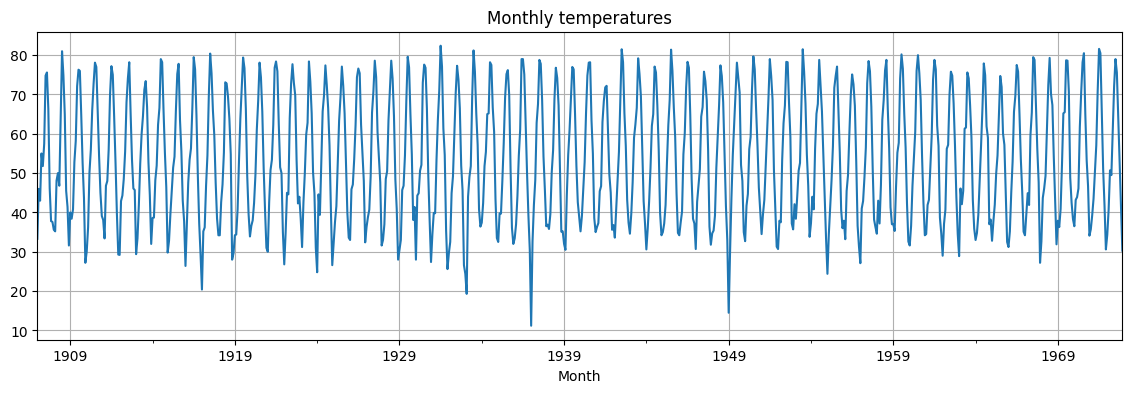

In [33]:
monthly_temp['temp'].plot(grid=True, figsize=(14, 4), title="Monthly temperatures");

We can make a presumption that our time serie is stationary from observing our plot

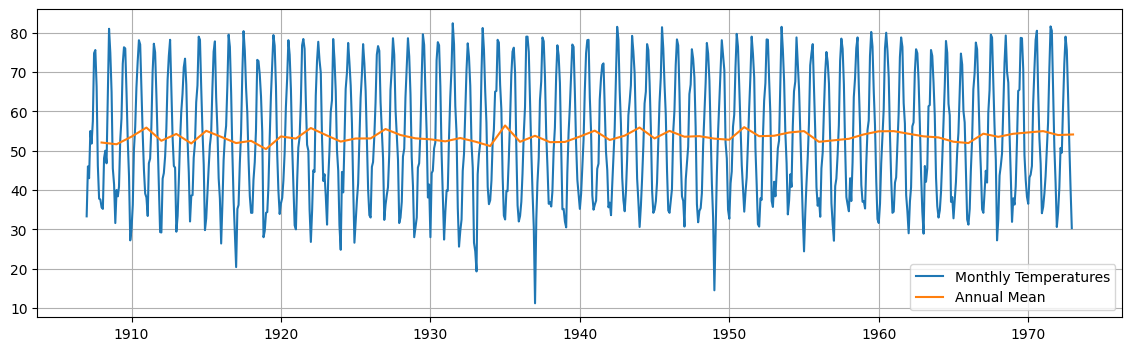

In [36]:
# Compute annual mean
annual_temp = monthly_temp.resample('YE').mean()
annual_temp.index.name = 'year'

plt.figure(figsize=(14, 4))
plt.plot(monthly_temp, label="Monthly Temperatures")
plt.plot(annual_temp, label="Annual Mean")
plt.grid(); plt.legend();

The mean seems almost constant overtime

## Seasonal Decomposition


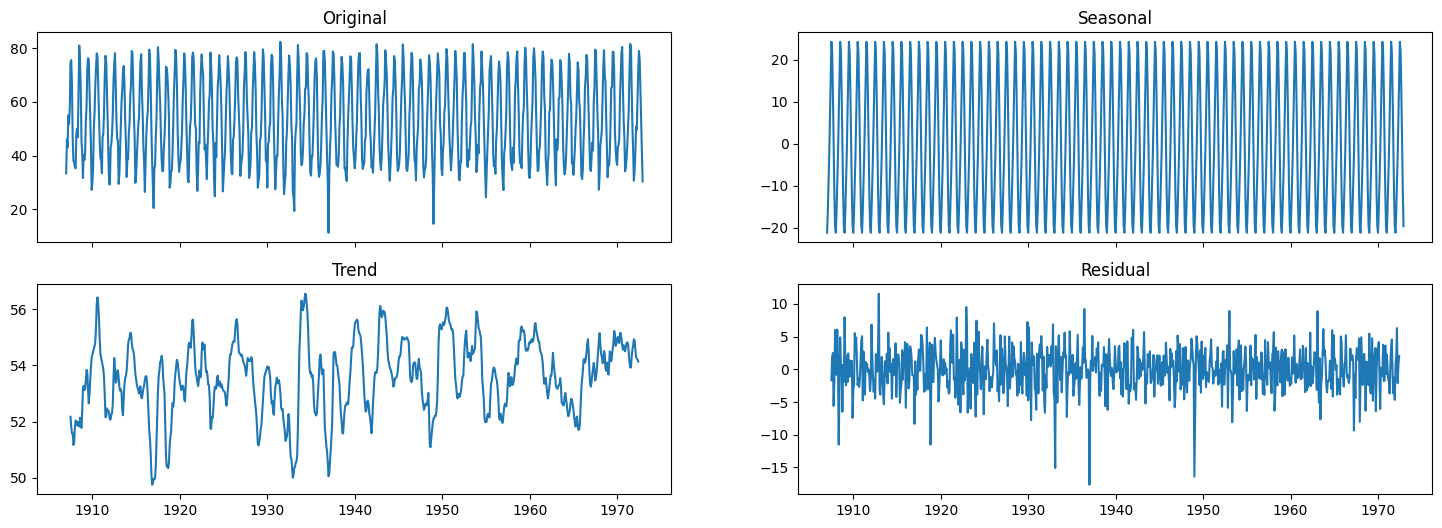

In [43]:
# seasonal Decomposition
decomposition = seasonal_decompose(x=monthly_temp['temp'], model='additive', period=12)

fig, axs = plt.subplots(2,2, sharex=True, figsize=(18,6))
axs[0,0].plot(monthly_temp['temp'])
axs[0,0].set_title('Original')
axs[0,1].plot(decomposition.seasonal)
axs[0,1].set_title('Seasonal')
axs[1,0].plot(decomposition.trend)
axs[1,0].set_title('Trend')
axs[1,1].plot(decomposition.resid)
axs[1,1].set_title('Residual')
plt.show()

The seasonality is well defined.

There doesn’t seem to be a strong, time-varying trend in the data; We can assume the trend is almost constant.

### stationarity

**Augmented Dickey Fuller test**

In [47]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid();

ADF Statistic: -6.48
p-value: 0.000
Critical Values: ['1%: -3.44', '5%: -2.87', '10%: -2.57']



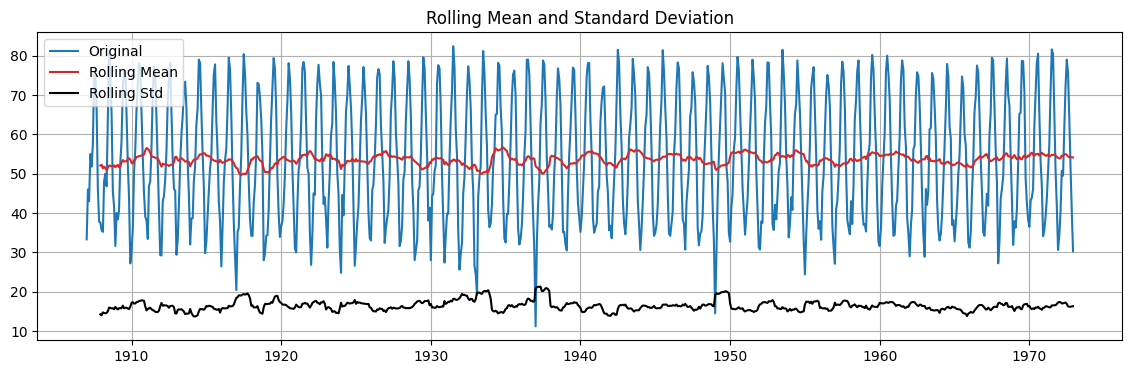

In [48]:
# run ADF on monthly temperatures
adftest(monthly_temp.temp)

p-value is very low, so we reject the null hypthesis.

This time serie is indeed stationary, even if it clearly has a periodic component

### Determine Seasonality
We can determine if seasonality is present by using the following tools:

1. Autocorrelation plot.
2. Seasonal subseries plot (month plot).
3. Fourier Transform.

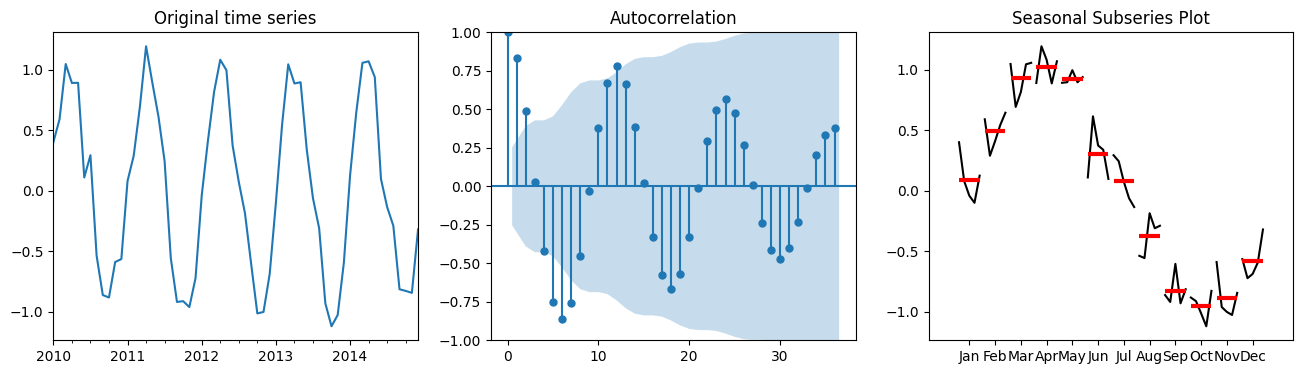

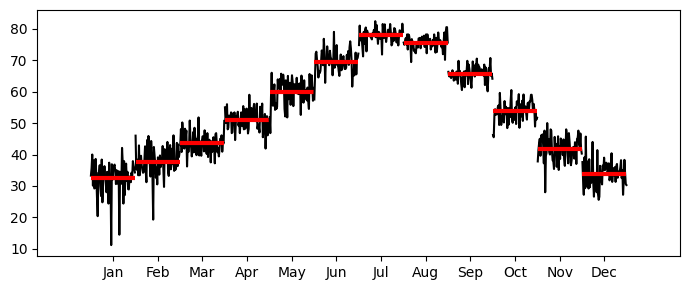

In [54]:
# Generate synthetic time series data
dates = pd.date_range(start='2010-01-01', periods=60, freq='M')  # Monthly data for 5 years
seas = 12 # change this and see how the plots change
data = (np.sin(np.arange(60)*2*np.pi/seas) +
        np.random.normal(loc=0, scale=0.2, size=60))  # Seasonal data with noise
series = pd.Series(data, index=dates)
fig, axes = plt.subplots(1,3,figsize=(16,4))
series.plot(ax=axes[0], title="Original time series")

# ACF Plot
plot_acf(series, lags=36, ax=axes[1]);

# Convert series to a DataFrame and add a column for the month
df = series.to_frame(name='Value')
df['Month'] = df.index.month

# Seasonal Subseries Plot
month_plot(df['Value'], ax=axes[2]); axes[2].set_title("Seasonal Subseries Plot");

_, ax = plt.subplots(1,1, figsize=(7,3))
month_plot(monthly_temp, ax=ax)
plt.tight_layout();

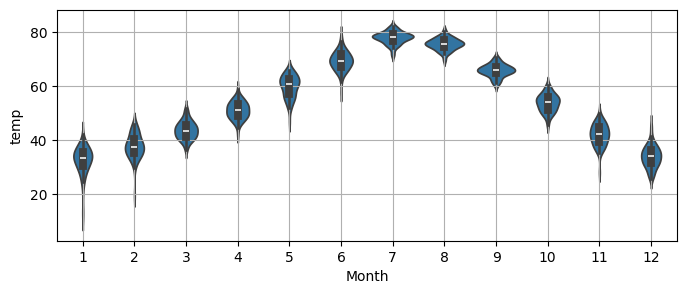

In [55]:
_, ax = plt.subplots(1,1, figsize=(8,3))
sns.violinplot(x=monthly_temp.index.month,
               y=monthly_temp.temp, ax=ax) # notice the indexing on the x by month
plt.grid();

Notice that a violinplot can give a very similar information to the month_plot.

Finally, to obtain the numerical value of the main periodicity we can use the Foruier Transfrom.

In [59]:
import numpy as np

def fft_analysis(signal):
    # Calculate the FFT
    fft_values = np.fft.fft(signal)

    # Calculate the frequencies
    frequencies = np.fft.fftfreq(len(signal))

    # Calculate the power spectrum
    power_spectrum = np.abs(fft_values)**2

    # Find the dominant frequency (excluding DC component)
    dominant_frequency = frequencies[np.argmax(power_spectrum[1:]) + 1]

    # Calculate the dominant period
    dominant_period = 1 / dominant_frequency if dominant_frequency != 0 else np.inf

    return dominant_period, frequencies, power_spectrum

dominant_period, _, _ = fft_analysis(monthly_temp['temp'].values)
print(f"Dominant period: {np.round(dominant_period)}")

Dominant period: 12.0


In this case, it is clear that the main seasonality is L=12.

We can remove it with a seasonal differencing.

In [60]:
monthly_temp['Seasonally_Differenced'] = monthly_temp['temp'].diff(12)

In [61]:
# Drop nan
monthly_temp_clean = monthly_temp.dropna()
monthly_temp_clean

,temp,Seasonally_Differenced
Month,,
1908-01-01,35.6,2.3
1908-02-01,35.2,-10.8
1908-03-01,48.1,5.1
1908-04-01,50.0,-5.0
1908-05-01,46.8,-5.0
...,...,...
1972-08-01,75.6,-4.9
1972-09-01,64.1,-1.7
1972-10-01,51.7,0.6


## Model Building

There are three stages in building an ARMA model:


1. Model identification.
2. Model estimation.
3. Model evaluation.

### 1. Model identification.
Model identification consists in finding the orders p and q of AR and MA components.

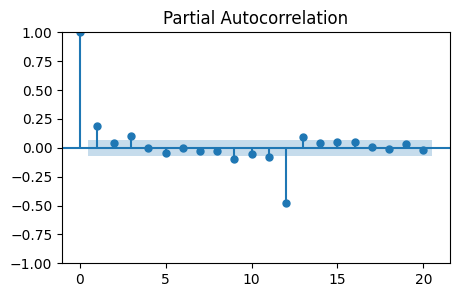

In [63]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

It looks like the PACF becomes zero at lag 2.

However there is a non-zero partial autocorrelation at lag 3.

The optimal value might be p = 1 , p = 2; p = 3.

Note that there are high partial autocorrelations at higher lags, especially 12.

* This is an effect from seasonality and seasonal differencing.

* It should not be accounted for when choosing p.

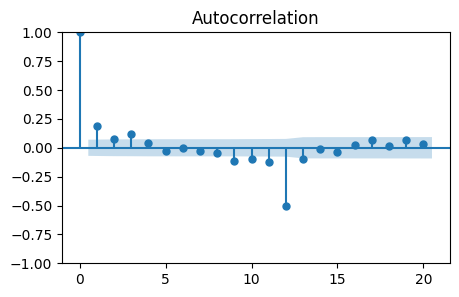

In [64]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(monthly_temp_clean['Seasonally_Differenced'], lags=20, ax=ax);

Also in this case there are non-zero autocorrelations at lags 1 and 3.

So, the values to try are q = 0, q = 1, or q = 3.

### 2. Model Estimation

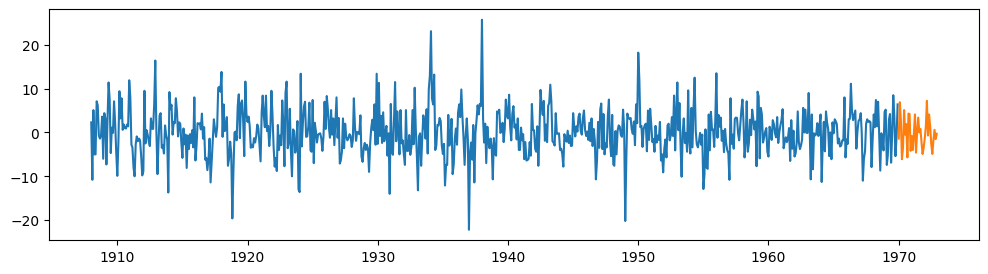

In [65]:
train = monthly_temp_clean['Seasonally_Differenced'][:-36]
test = monthly_temp_clean['Seasonally_Differenced'][-36:]

plt.figure(figsize=(12,3))
plt.plot(train)
plt.plot(test);

In [66]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

print(fit_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Seasonally_Differenced   No. Observations:                  744
Model:                     ARIMA(3, 0, 3)   Log Likelihood               -2248.119
Date:                    Fri, 04 Apr 2025   AIC                           4512.238
Time:                            22:19:44   BIC                           4549.134
Sample:                        01-01-1908   HQIC                          4526.460
                             - 12-01-1969                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0644      0.245      0.263      0.793      -0.416       0.544
ar.L1         -0.0891      0.137     -0.648      0.517      -0.358       0.180
ar.L2         -0.830

### 3. Model Evaluation
**Residulas Analyis**

The residuals shoul follow a white noise process

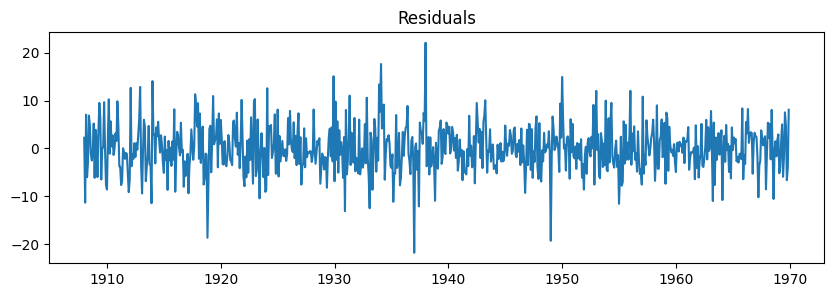

In [67]:
residuals = fit_model.resid

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Residuals");

To test that the residuals follow a white noise process, We can use both visual inspection and statistical tests.

**Visual inspection:**

* ACF plot.

* Histogram.

* QQ plot.

**Statistical tests:**

* Normality.

* Autocorrelation.

* Heteroskedasticity.

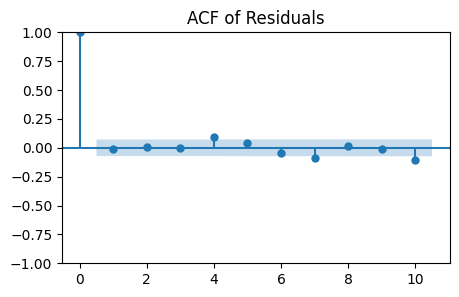

In [68]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(residuals, lags=10, ax=ax)
plt.title('ACF of Residuals');

There is no significant autocorrelation between residuals: white noise process assumption validated

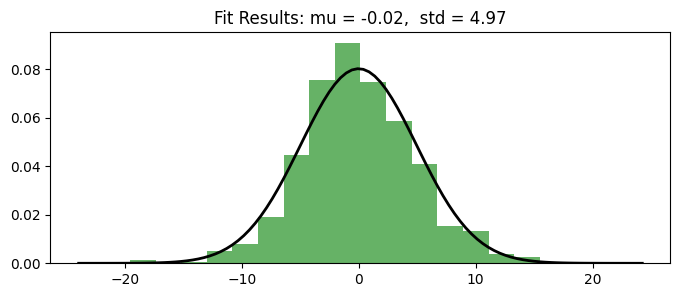

In [70]:
from scipy import stats # Import the stats module from scipy

plt.figure(figsize=(8,3))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g') # Histogram
# Add the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals)) # Now stats is defined and can be used
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Results: mu = %.2f,  std = %.2f" % (np.mean(residuals), np.std(residuals))
plt.title(title);

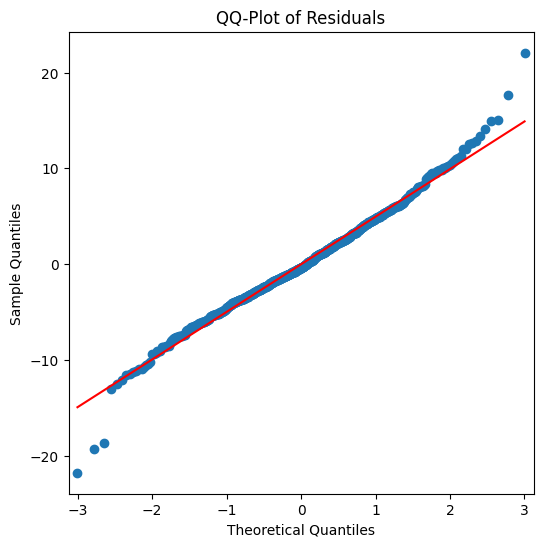

In [73]:
import statsmodels.api as sm
# QQ-Plot
_, ax = plt.subplots(1, 1, figsize=(6, 6))
sm.qqplot(residuals, line='s', ax=ax) # Use sm.qqplot to call the function from statsmodels
plt.title('QQ-Plot of Residuals');

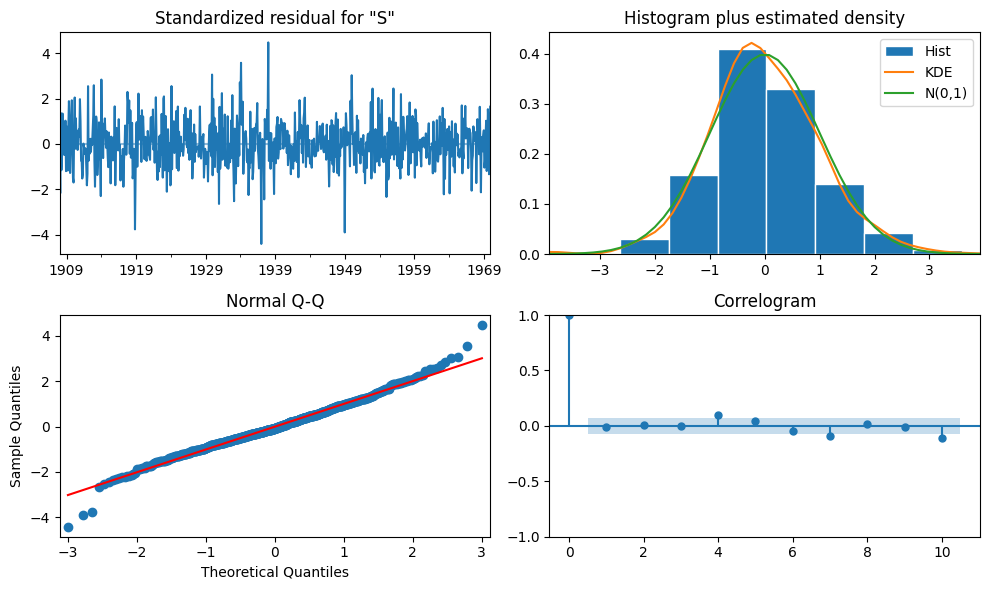

In [74]:
fit_model.plot_diagnostics(figsize=(10, 6))
plt.tight_layout();

**Statistical tests**

**Normality: Jarque-Bera and Shapiro-Wilk tests**

H0: Residuas are normally distributed

In [76]:
norm_val, norm_p, skew, kurtosis = fit_model.test_normality('jarquebera')[0]
print('Normality (Jarque-Bera) p-value:{:.3f}'.format(norm_p))


Normality (Jarque-Bera) p-value:0.000


In [77]:
shapiro_test = stats.shapiro(residuals)
print(f'Normality (Shapiro-Wilk) p-value: {shapiro_test.pvalue:.3f}')

Normality (Shapiro-Wilk) p-value: 0.000


The small p-values allow us to reject H0.
However, these tests usually start to be reliable only for large sample sizes (N>5000).

**Autocorrelation: Ljung-Box test**

H0: the residuals are independently distributed (no autocorrelation).

In [78]:
statistic, pval = fit_model.test_serial_correlation(method='ljungbox', lags=10)[0]
print(f'Ljung-Box p-value: {pval.mean():.3f}')

Ljung-Box p-value: 0.343


**Autocorrelation: Durbin Watson test**

In [80]:
import statsmodels.stats.stattools as ss # Import the stattools module with alias ss

durbin_watson = ss.durbin_watson( # Use ss to call durbin_watson
    fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Durbin-Watson: d=2.01


Independence Assumption is validated

**Heteroskedasticity test**

Tests for change in variance between residuals.

H0: no heteroskedasticity.

H0 indicates different things based on the alternative H1:

H1: Increasing,
H0:  the variance is not increasing throughout the series.

H1: Decreasing,
H0: the variance is not decreasing throughout the series.

H1: Two-sided (default),
H0:  the variance does not increase nor decrease throughout the series.

In [81]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='increasing')[0]
print(f'H_a: Increasing - pvalue:{pval:.3f}')

H_a: Increasing - pvalue:0.980


In [82]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='decreasing')[0]
print(f'H_a: Decreasing - pvalue:{pval:.3f}')

H_a: Decreasing - pvalue:0.020


In [83]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='two-sided')[0]
print(f'H_a: Two-sided - pvalue:{pval:.3f}')

H_a: Two-sided - pvalue:0.040


### Tests Summary:
**Independence:**

✅ ACF plot.

✅ Ljung-Box test.

✅ Durbin Watson test.

**Normality:**

✅ Histogram/Density plot.

🤔 QQ-plot

❌ Jarque-Bera (reliable for large sample size).

❌ Shapiro-Wilk (reliable for large sample size).

**Heteroskedasticity: **

❌ Heteroskedasticity test.


- The tests are a bit inconclusive.

- There is no strong evidence that the model is either very good or very bad.

It is probably wise to try other candidate models and repeat the tests.

In [144]:
model = ARIMA(train, order=(4, 0, 2))
fit_model = model.fit()

print(fit_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Seasonally_Differenced   No. Observations:                  744
Model:                     ARIMA(4, 0, 2)   Log Likelihood               -2248.092
Date:                    Sat, 05 Apr 2025   AIC                           4512.185
Time:                            00:00:44   BIC                           4549.081
Sample:                        01-01-1908   HQIC                          4526.407
                             - 12-01-1969                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0822      0.242     -0.339      0.734      -0.557       0.392
ar.L1          0.1429      0.037      3.889      0.000       0.071       0.215
ar.L2         -0.856

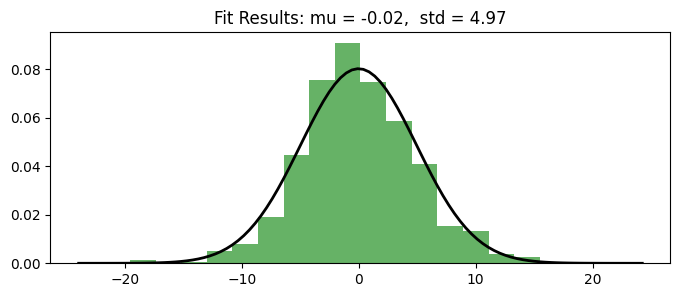

In [145]:
#Normality:Histogram
plt.figure(figsize=(8,3))
plt.hist(residuals, bins=20, density=True, alpha=0.6, color='g') # Histogram
# Add the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Results: mu = %.2f,  std = %.2f" % (np.mean(residuals), np.std(residuals))
plt.title(title);

The normality assumption is validated.

In [146]:
#Autocorrelation: Durbin Watson test
import statsmodels.stats.stattools as ss # Import the stattools module with alias ss

# Use ss.durbin_watson to call the function directly
durbin_watson = ss.durbin_watson(
    fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Durbin-Watson: d=1.99


1 < d = 1.99 < 3:

The independence assumption is validated

After testing multiple Models, the optimal one, with the lowest AIC, BIC, and JB test is ARIMA(4, 0, 2)

## ARMA Model Predictions

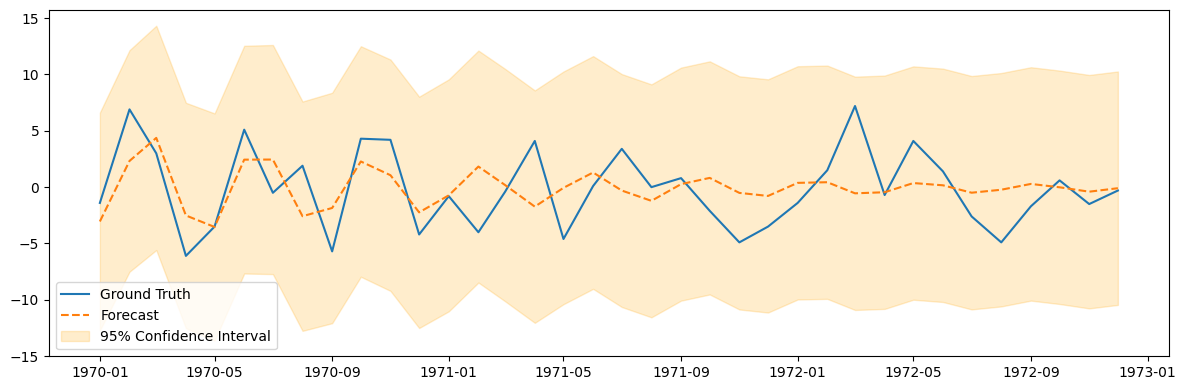

In [147]:
pred_summary = fit_model.get_prediction(test.index[0], test.index[-1]).summary_frame()

plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label='Ground Truth')
plt.plot(test.index, pred_summary['mean'], label='Forecast', linestyle='--')
plt.fill_between(test.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.tight_layout();